In [2]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
import torch
from tqdm import tqdm
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import random
import tqdm.notebook as tqdm
import copy
import altair as alt

In [4]:


df = pd.read_csv("https://raw.githubusercontent.com/MitchLeahy/Stock-Trading-Bot-A2C-PPO/main/AAPL.csv")


df['Date'] = pd.to_datetime(df['Date'])

# sort date values
df = df.sort_values('Date',ascending=True)
try:
    df.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

#2020 Jan - 2021 Dec
start_idx = 5535 
end_idx = 6039

# 2022 Jan - 2022 Nov
test_start = 6040
test_end = 6270

In [78]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMAl,SMAh,RSI,MACD
Date,,,,,,,,,,
1998-01-02,0.121652,0.145089,0.120536,0.145089,0.123676,718110400,0.0,0.0,0.000000,0.000000
1998-01-05,0.147321,0.147879,0.135603,0.141741,0.120823,651873600,0.0,0.0,0.000000,0.001004
1998-01-06,0.142299,0.178571,0.131696,0.169085,0.144131,1812473600,0.0,0.0,89.791246,0.000825
1998-01-07,0.167969,0.169643,0.154576,0.156250,0.133190,1041622400,0.0,0.0,61.759228,0.003295
1998-01-08,0.155692,0.166295,0.151228,0.162388,0.138422,774020800,0.0,0.0,67.056012,0.003809


In [6]:
df.set_index('Date', inplace=True)

## Importing Finta (adds additon features)

In [80]:
# pip install finta
from finta import TA
from gym_anytrading.envs import StocksEnv

## Fix Volume data type

In [81]:
# df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(',', '')))

# Calculate indicators using TA(finta)

In [82]:
df['SMAl'] = TA.SMA(df, 10, column = 'Low')
df['SMAh'] = TA.SMA(df, 10, column = 'High')
df['RSI'] = TA.RSI(df)
df['MACD'] = TA.MACD(df, period_fast = 5, period_slow = 15, column = 'Low').MACD
df.fillna(0, inplace=True)


In [85]:
#SMA of the first couple days are zero due to lake of information
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMAl,SMAh,RSI,MACD
Date,,,,,,,,,,
1998-01-02,0.121652,0.145089,0.120536,0.145089,0.123676,718110400,0.0,0.0,0.000000,0.000000
1998-01-05,0.147321,0.147879,0.135603,0.141741,0.120823,651873600,0.0,0.0,0.000000,0.001004
1998-01-06,0.142299,0.178571,0.131696,0.169085,0.144131,1812473600,0.0,0.0,89.791246,0.000825
1998-01-07,0.167969,0.169643,0.154576,0.156250,0.133190,1041622400,0.0,0.0,61.759228,0.003295
1998-01-08,0.155692,0.166295,0.151228,0.162388,0.138422,774020800,0.0,0.0,67.056012,0.003809


# Apply new signals to enviornment and write custom reward function


In [13]:
def add_signals(env):
    # get the start index of the env
    start = env.frame_bound[0] - env.window_size
    # get the end index of the env
    end = env.frame_bound[1]
    # get the target data from the env
    target = env.df.loc[:,'Low'].to_numpy()[start:end]
    # get the signal data from the env
    signal_features = env.df.loc[:,['Low','Volume','RSI', 'MACD', 'SMAl', 'SMAh']].to_numpy()[start:end]

    return target, signal_features

def calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff
        if self._position == Positions.Long and self.prices[self._current_tick] - self.prices[self._current_tick - 1]> 0:
            step_reward += self.prices[self._current_tick] - self.prices[self._current_tick - 1]
        if self._position == Positions.Short and self.prices[self._current_tick] - self.prices[self._current_tick - 1] < 0:
            step_reward += -1 *(self.prices[self._current_tick] - self.prices[self._current_tick - 1])
        return step_reward

In [14]:
class CustomEnv(StocksEnv):
    _process_data = add_signals
    _calculate_reward = calculate_reward

In [15]:
#function to create weights for our network to begin with
def customized_weights_init(m):
    gain = nn.init.calculate_gain('relu')
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
# ERM This is the object that will hold all the instances tht we experience  
class ReplayBuffer(object):
    def __init__(self, buffer_size):
        self.total_size = buffer_size
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        trans = (obs, act, reward, next_obs, done)

        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []

        for idx in indices:
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))

        return np.array(obs_list), np.array(actions_list), np.array(rewards_list), np.array(next_obs_list), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

# functino to decay epsilon greedy policy over time
class LinearSchedule(object):
    def __init__(self, start_value, end_value, duration):
        self._start_value = start_value
        self._end_value = end_value
        self._duration = duration
        self._schedule_amount = end_value - start_value
        
        self.epsilons = np.linspace(self._start_value, self._end_value, self._duration)

    def get_value(self, time):
        if time >= self._duration:
            return self._end_value
        else:
            return self.epsilons[time]

# the actual neural nets themselves
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layer, dim_hidden_layer, output_dim):
        super(DeepQNet, self).__init__()
        self.input_dim = input_dim
        self.hidden_num = num_hidden_layer
        self.hidden_dim = dim_hidden_layer
        self.output_dim = output_dim

        
        
        
        self.layers = nn.ModuleList(
            [nn.Linear(self.hidden_dim[i], self.hidden_dim[i+1]) for i in range(self.hidden_num - 1)] +
            [nn.Linear(self.hidden_dim[-1], self.hidden_dim[-1])])
        
        self.input = nn.Linear(self.input_dim, self.hidden_dim[0])
        self.activation = nn.ReLU()
        self.output = nn.Linear(self.hidden_dim[-1], self.output_dim)
        
# Function to perform forward propagation
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        for i in range(self.hidden_num):
            x = self.layers[i](x)
            x = self.activation(x)
        y = self.output(x)
        return y

# the agent itself that will both interact with the environment and update our networks
class DQNAgent(object):
    def __init__(self,
                 params,
                 ):
        self.params = params

        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        self.action_space = params['action_space']

        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                   num_hidden_layer=params['hidden_layer_num'],
                                   dim_hidden_layer=params['hidden_layer_dim'],
                                   output_dim=params['action_dim'])
        
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          num_hidden_layer=params['hidden_layer_num'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network and use the customized weights initialization
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:
            action = np.random.choice(self.action_space, 1)[0]
            return action
        else:
            obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = q_values.max(dim=1)[1].item()
            return self.action_space[int(action)]
        
    def get_action_test(self, obs):
        obs = self._arr_to_tensor(obs).view(1, -1)
        with torch.no_grad():
            q_values = self.target_policy_net(obs)
            action = q_values.max(dim=1)[1].item()
        return self.action_space[int(action)]
    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_size = len(batch_data)
        batch_data_tensor = self._batch_to_tensor(batch_data)

        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']

        # compute the q value estimation using the behavior network
        state_action_val = self.behavior_policy_net.forward(obs_tensor).gather(1, actions_tensor)
        # compute the TD target using the target network
        done_mask = dones_tensor.bool()
        next_state_values = self.target_policy_net.forward(next_obs_tensor).max(1)[0].detach()
        expected_state_action_val = (next_state_values.multiply(self.params['gamma'])).reshape(-1,1) + rewards_tensor
        expected_state_action_val[done_mask] = rewards_tensor[done_mask]
        # compute the loss
        loss_func = nn.MSELoss()
        td_loss = loss_func(state_action_val, expected_state_action_val)
        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()
        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())


    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

        return batch_data_tensor

# class to perform both the training and the testing of the DQN agent
class Train_Test:
    
    def __init__(self, trainenv, testenv, params):
        self.trainenv  = trainenv
        self.testenv = testenv
        self.params = params
        
        
        self.my_agent = DQNAgent(self.params)
        
    def train_dqn_agent(self):
        params = self.params
        env = self.trainenv
        # create the DQN agent
        my_agent = self.my_agent

        # create the epsilon-greedy schedule
        my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                     end_value=params['epsilon_end_value'],
                                     duration=params['epsilon_duration'])

        # create the replay buffer
        replay_buffer = ReplayBuffer(params['replay_buffer_size'])

        # training variables
        episode_t = 0
        rewards = []
        train_returns = []
        train_loss = []
        loss = 0

        # reset the environment
        obs = env.reset().flatten()
        # start training
        pbar = tqdm.trange(params['total_training_time_step'])
        last_best_return = 0
        for t in pbar:
            # scheduled epsilon at time step t
            eps_t = my_schedule.get_value(t)
            # get one epsilon-greedy action
            action = my_agent.get_action(obs, eps_t)
            
            # step in the environment
            next_obs, reward, done, _ = env.step(action)
            next_obs = next_obs.flatten()
            # add to the buffer
            replay_buffer.add(obs, action, reward, next_obs, done)
            rewards.append(reward)
            # check termination
            if done:
                # compute the return
                G = 0
                for r in reversed(rewards):
                    G = r + params['gamma'] * G

                if G > last_best_return:
                    torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}"
                              )
                # store the return
                train_returns.append(G)
                episode_idx = len(train_returns)

                # print the information
                pbar.set_description(
                    f"Ep={episode_idx} | "
                    f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                    f"Eps={eps_t}"
                )

                # reset the environment
                episode_t, rewards = 0, []
                obs = env.reset().flatten()
            else:
                # increment
                obs = next_obs
                episode_t += 1

            if t > params['start_training_step']:
                # update the behavior model
                if not np.mod(t, params['freq_update_behavior_policy']):

                    tloss = my_agent.update_behavior_policy(replay_buffer.sample_batch(my_agent.params['batch_size']))
                    train_loss.append(tloss)
                # update the target model
                if not np.mod(t, params['freq_update_target_policy']):
                    my_agent.update_target_policy()

        # save the results
        return train_returns, train_loss, my_agent.target_policy_net.state_dict()


    def test_agent(self, model_dict):
        env = self.testenv
        agent = self.my_agent
        obs = env.reset()
        record = []
        while True:
            action = agent.get_action_test(obs.flatten())
            obs, reward, done, info = env.step(action)
            #record.append(np.array([obs, reward, done, info]))
            if done:
                break
        return record

# function to plot both the returns and learning of the agent over time
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])

        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)

        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)

        h_list.append(h)


    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [57]:
start_idx = 5535
end_idx = 6039

In [58]:
df.iloc[start_idx:end_idx]

,Open,High,Low,Close,Adj Close,Volume,SMAl,SMAh,RSI,MACD
Date,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,71.066750,72.144750,84.583740,1.935480
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.846367,146322800,71.501250,72.611750,77.703693,2.082012
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.426826,118387200,71.846250,73.081250,79.183673,1.885427
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.081505,108872000,72.319250,73.537500,75.953554,1.938547
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.257103,132079200,72.739001,74.042250,79.081929,1.872094
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.279999,175.262817,68356600,171.918001,177.010002,62.880969,2.835671
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.289444,74919600,172.156001,177.089001,66.890408,3.523961
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255432,79144300,172.456001,177.009001,64.950263,4.082796


In [59]:
CustomEnv(df=df, frame_bound=(start_idx,end_idx), window_size=5 ).reset()

array([[7.11750030e+01, 9.31212000e+07, 7.86789981e+01, 1.56624254e+00,
        6.94662506e+01, 7.03817496e+01],
       [7.20299990e+01, 1.46266000e+08, 7.84056592e+01, 1.71764320e+00,
        6.99862503e+01, 7.09169997e+01],
       [7.13050000e+01, 1.44114400e+08, 7.95989659e+01, 1.58335033e+00,
        7.03435005e+01, 7.13517501e+01],
       [7.23799970e+01, 1.00805600e+08, 8.09992600e+01, 1.66299760e+00,
        7.06569999e+01, 7.16739997e+01],
       [7.37975010e+01, 1.35480400e+08, 8.45837405e+01, 1.93548027e+00,
        7.10667503e+01, 7.21447502e+01]])

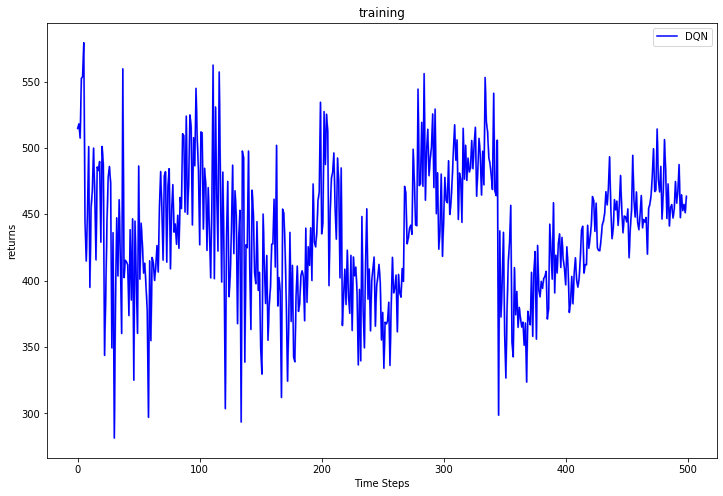

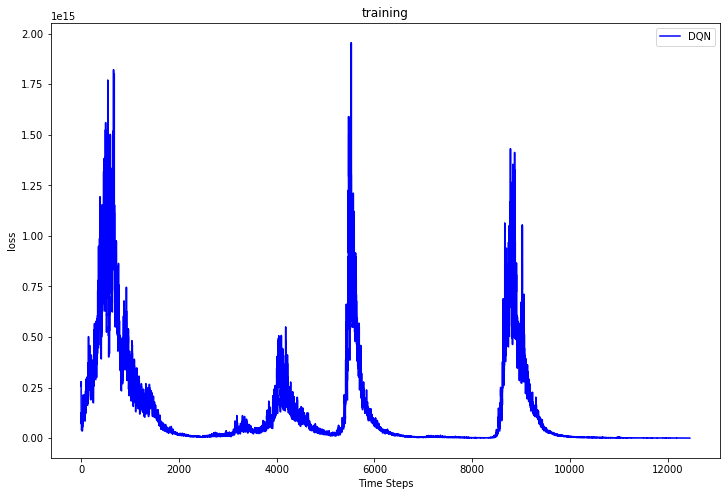

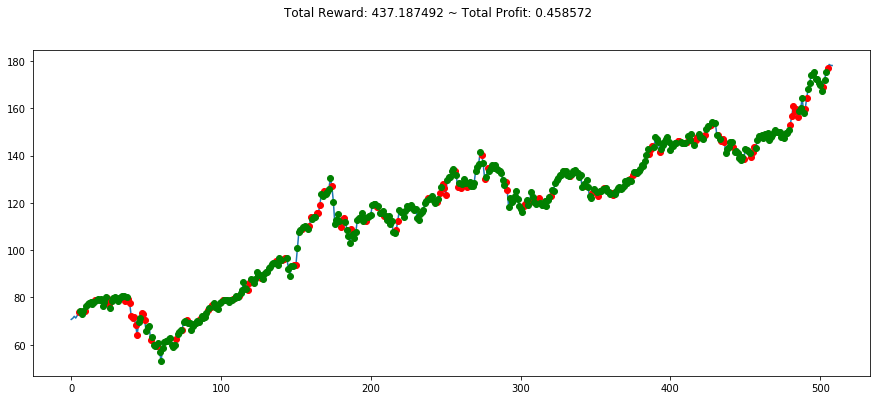

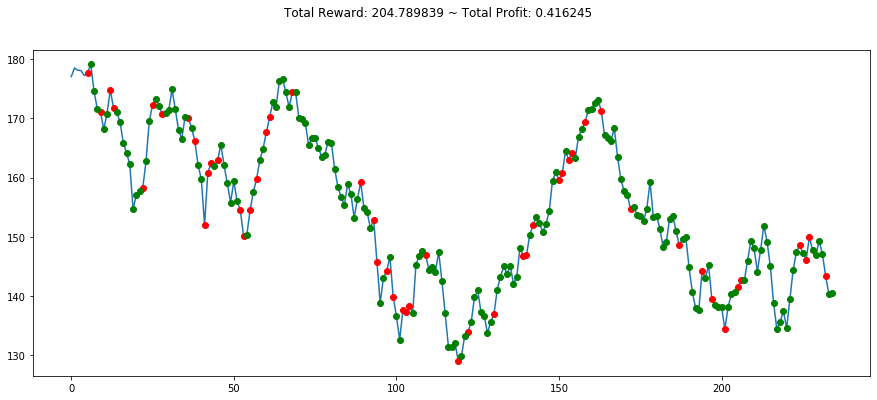

In [61]:
if __name__ == '__main__':
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    # create training environment
    my_env = CustomEnv(df=df, frame_bound=(start_idx,end_idx), window_size=5 )
    # 

    test_env = CustomEnv(df=df, frame_bound=(test_start, test_end), window_size=5, )
    # create training parameters
    train_parameters = {
        'observation_dim': np.shape(my_env.observation_space)[0] * np.shape(my_env.observation_space)[1],
        'action_dim': 2,
        'action_space': [0,1],
        'hidden_layer_num': 3,
        'hidden_layer_dim': [30, 200, 16],
        'gamma': 1,

        'total_training_time_step': 500 *(end_idx - start_idx) ,

        'epsilon_start_value': .1,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 300 * (end_idx - start_idx),

        'replay_buffer_size': 6000,
        'start_training_step': 3000,
        'freq_update_behavior_policy': 20,
        'freq_update_target_policy': 50,

        'batch_size': 260,
        'learning_rate': 1e-2,

        'model_name': "four_room.pt"
    }

    # create experiment
    TnT = Train_Test(my_env, test_env, train_parameters)

    returns, loss, diction = TnT.train_dqn_agent()
    plot_curves([np.array([returns])], ['DQN'], ['b'], 'returns', 'training')
    plot_curves([np.array([loss])], ['DQN'], ['b'], 'loss', 'training')
    
    plt.figure(figsize=(15,6))
    plt.cla()
    my_env.render_all()
    plt.show()
    
    tracker = TnT.test_agent(diction)
    plt.figure(figsize=(15,6))
    plt.cla()
    test_env.render_all()
    plt.show()

In [92]:
test_df = copy.copy(test_env.df[test_start: test_end -1])
train_df = copy.copy(my_env.df[start_idx: start_idx + len(my_env.history['position'])])

In [93]:
test_df['position'] = test_env.history['position']
train_df['position'] = my_env.history['position']
test_df['date'] = test_df.index
train_df['date'] = train_df.index

In [94]:
test_df

,Open,High,Low,Close,Adj Close,Volume,SMAl,SMAh,RSI,MACD,position,date
Date,,,,,,,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,180.959747,104487900,175.080000,178.155002,66.600031,3.293026,1,2022-01-03
2022-01-04,182.630005,182.940002,179.119995,179.699997,178.663086,99310400,176.245999,179.391002,61.901244,3.273258,1,2022-01-04
2022-01-05,179.610001,180.169998,174.639999,174.919998,173.910645,94537600,176.798000,180.088002,53.491261,2.192008,1,2022-01-05
2022-01-06,172.699997,175.300003,171.639999,172.000000,171.007523,96904000,176.747000,180.032002,49.102530,0.844946,0,2022-01-06
2022-01-07,172.889999,174.139999,171.029999,172.169998,171.176514,86709100,176.322999,179.761001,49.363007,-0.103130,1,2022-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22,148.130005,150.419998,146.929993,150.179993,150.179993,51804100,145.250996,149.413997,54.066789,2.034189,1,2022-11-22
2022-11-23,149.449997,151.830002,149.339996,151.070007,151.070007,58301400,146.725996,150.741997,55.125032,2.227357,1,2022-11-23
2022-11-25,148.309998,148.880005,147.119995,148.110001,148.110001,35195900,147.487996,150.942998,50.923058,1.784732,0,2022-11-25


In [95]:
(alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='Close'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('Close'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
)).properties(
    width = 1000,
    height = 500
)


alt.LayerChart(...)

In [96]:
(alt.Chart(train_df).mark_line().encode(
    x=alt.X('date'),
    y='Close'
) + alt.Chart(train_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('Close'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
)).properties(
    width = 1000,
    height = 500
)

alt.LayerChart(...)

In [97]:
alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='Volume'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('Volume'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
).properties(
    width = 1000,
    height = 500
)

alt.LayerChart(...)

In [98]:
alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='SMAl'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('SMAl'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
).properties(
    width = 1250,
    height = 500
)

alt.LayerChart(...)

In [99]:
alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='SMAh'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('SMAh'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
).properties(
    width = 1250,
    height = 500
)

alt.LayerChart(...)

In [100]:
alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='RSI'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('RSI'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
).properties(
    width = 1000,
    height = 500
)

alt.LayerChart(...)

In [101]:
alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='MACD'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('MACD'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
).properties(
    width = 1000,
    height = 500
)

alt.LayerChart(...)

In [103]:
# calculating the overall portfolio value over test data
pos = list(test_df['position'])
close = list(test_df['Close'])
record = []
first = True
cash = 0
for i in range(0,len(pos)):
    if pos[i] == 1:
        stock_val = close[i]
    if pos[i] == 1 and pos[i - 1] == 0:
        cash -= close[i]
    if pos[i] == 0 and pos[i - 1] == 1:
        cash += close[i]
        stock_val = 0
    record.append(cash+ stock_val)

test_df['portfolio_value'] = record

In [104]:
alt.Chart(test_df).mark_line().encode(
    x = 'date',
    y = 'portfolio_value'
).properties(
    width = 1000,
    height = 500
)

alt.Chart(...)